This notebook is "forked" from the notebook of the Fastai courses, lesson 2. 
It shows how to easily train an almost state-of-the-art (0.93 accuracy) Car Classifier using resnet34.
The final model (saved as "export.pkl") is available <a href="https://www.dropbox.com/s/jyoruifmgtwf5go/export.pkl?raw=1">here</a>
and is part of the <a href="https://github.com/H4dr1en/car-classifier/edit/master/README.md">Car Classifier project</a>.

## Imports and Definitions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [1]:
import scipy.io
import numpy as np
import pickle
from pathlib import Path

In [3]:
bs = 46
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
path = Path("./data")
path_imgs = Path("./data/cars_train")

## Looking at the data

In [ ]:
data = scipy.io.loadmat(path/"devkit/cars_train_annos.mat")

for i in data:
    if '__' not in i and 'readme' not in i:
        with open(path/"train_labels.pkl", 'wb') as pickle_file:
            pickle.dump(data[i],pickle_file)
        #np.savetxt(("data/devkit/cars_train.txt"),data[i],delimiter=',')    

In [98]:
with open(path/"train_labels.csv", 'a') as f:
    for i in range(labels.shape[1]):
        f.write(str(labels[0][i][4][0][0])+","+labels[0][i][5][0]+"\n")

In [4]:
with open(path/"devkit/cars_meta.txt") as fp:
    lines = fp.read().splitlines()

In [25]:
with open(path/"train_labels.csv") as f_train_labels:
    with open(path/"train_labels_clean.csv", 'a') as f_train_labels_c:
        for line in f_train_labels:
            vals = line.split(",")
            f_train_labels_c.write(lines[int(vals[0])-1] + "," + vals[1])

In [6]:
lines

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [101]:
fnames = get_image_files(path_imgs)
fnames[:5]

[WindowsPath('data/cars_train/00001.jpg'),
 WindowsPath('data/cars_train/00002.jpg'),
 WindowsPath('data/cars_train/00003.jpg'),
 WindowsPath('data/cars_train/00004.jpg'),
 WindowsPath('data/cars_train/00005.jpg')]

In [5]:
df = pd.read_csv(path/'train_labels.csv', header=None, names=['label', 'name'])
df.head()

,label,name
0,14,00001.jpg
1,3,00002.jpg
2,91,00003.jpg
3,134,00004.jpg
4,106,00005.jpg


In [127]:
import os
for _, j in df.iterrows():
    if not os.path.isfile(path_imgs/j["name"]): print(j["name"])

In [4]:
data = ImageDataBunch.from_csv(path, 
                               folder="cars_train", 
                               csv_labels="train_labels.csv",
                               fn_col=1, 
                               label_col=0,
                               ds_tfms=get_transforms(),
                               bs=bs,
                               size=224,
                               num_workers=8).normalize(imagenet_stats)

In [6]:
np.random.seed(2)

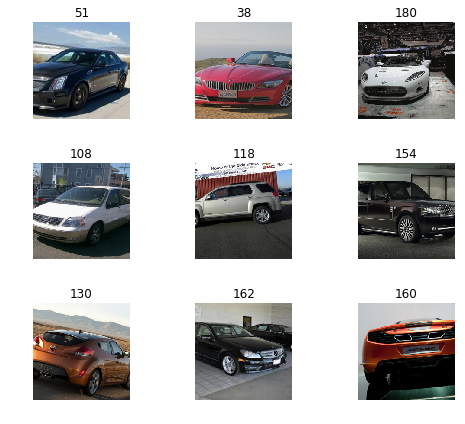

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [6]:
print(data.classes)
len(data.classes),data.c

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]


(196, 196)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 196 outputs).

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [7]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [12]:
learn.fit_one_cycle(5, max_lr = slice(None, 1e-2, None))

epoch,train_loss,valid_loss,error_rate
1,4.658802,3.563119,0.806511
2,3.516411,2.665824,0.671990
3,2.694411,2.060176,0.540541
4,2.075533,1.703563,0.444103
5,1.697856,1.635408,0.426904


In [8]:
learn.freeze()
learn.fit_one_cycle(3, max_lr = slice(None, 1e-3, None))

epoch,train_loss,valid_loss,error_rate
1,1.760903,0.990172,0.242015
2,1.673802,0.983015,0.243857
3,1.606961,0.977693,0.247543


In [9]:
learn.save('stage-1-e8')

In [8]:
learn.load('stage-1-e5')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (6515 items)
[Category 3, Category 91, Category 106, Category 123, Category 96]...
Path: data
x: ImageItemList (6515 items)
[Image (3, 675, 900), Image (3, 480, 640), Image (3, 108, 144), Image (3, 431, 575), Image (3, 480, 639)]...
Path: data;

Valid: LabelList
y: CategoryList (1628 items)
[Category 83, Category 83, Category 66, Category 72, Category 191]...
Path: data
x: ImageItemList (1628 items)
[Image (3, 225, 300), Image (3, 225, 300), Image (3, 1067, 1600), Image (3, 480, 640), Image (3, 480, 640)]...
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, ker

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

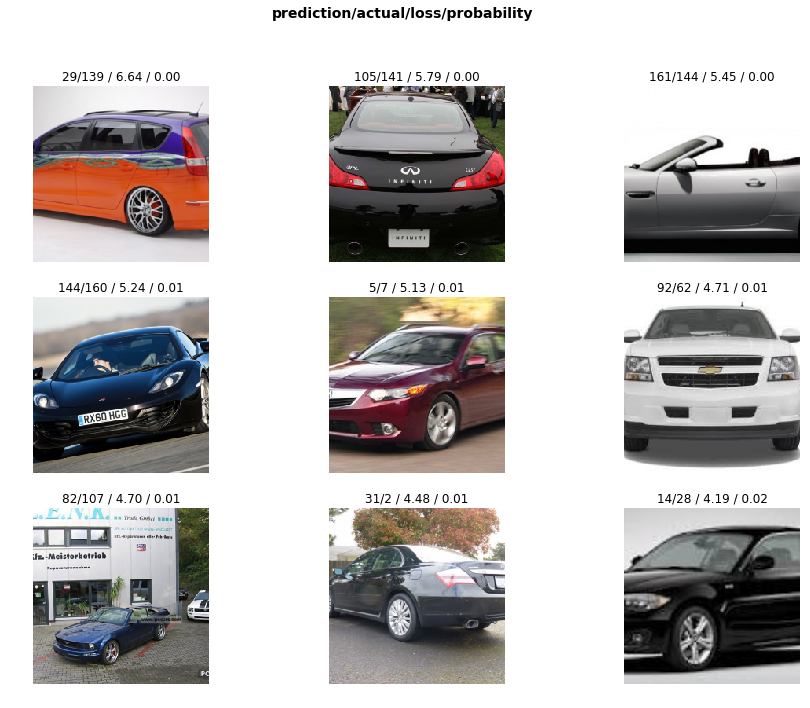

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

In [11]:
doc(interp.plot_top_losses)

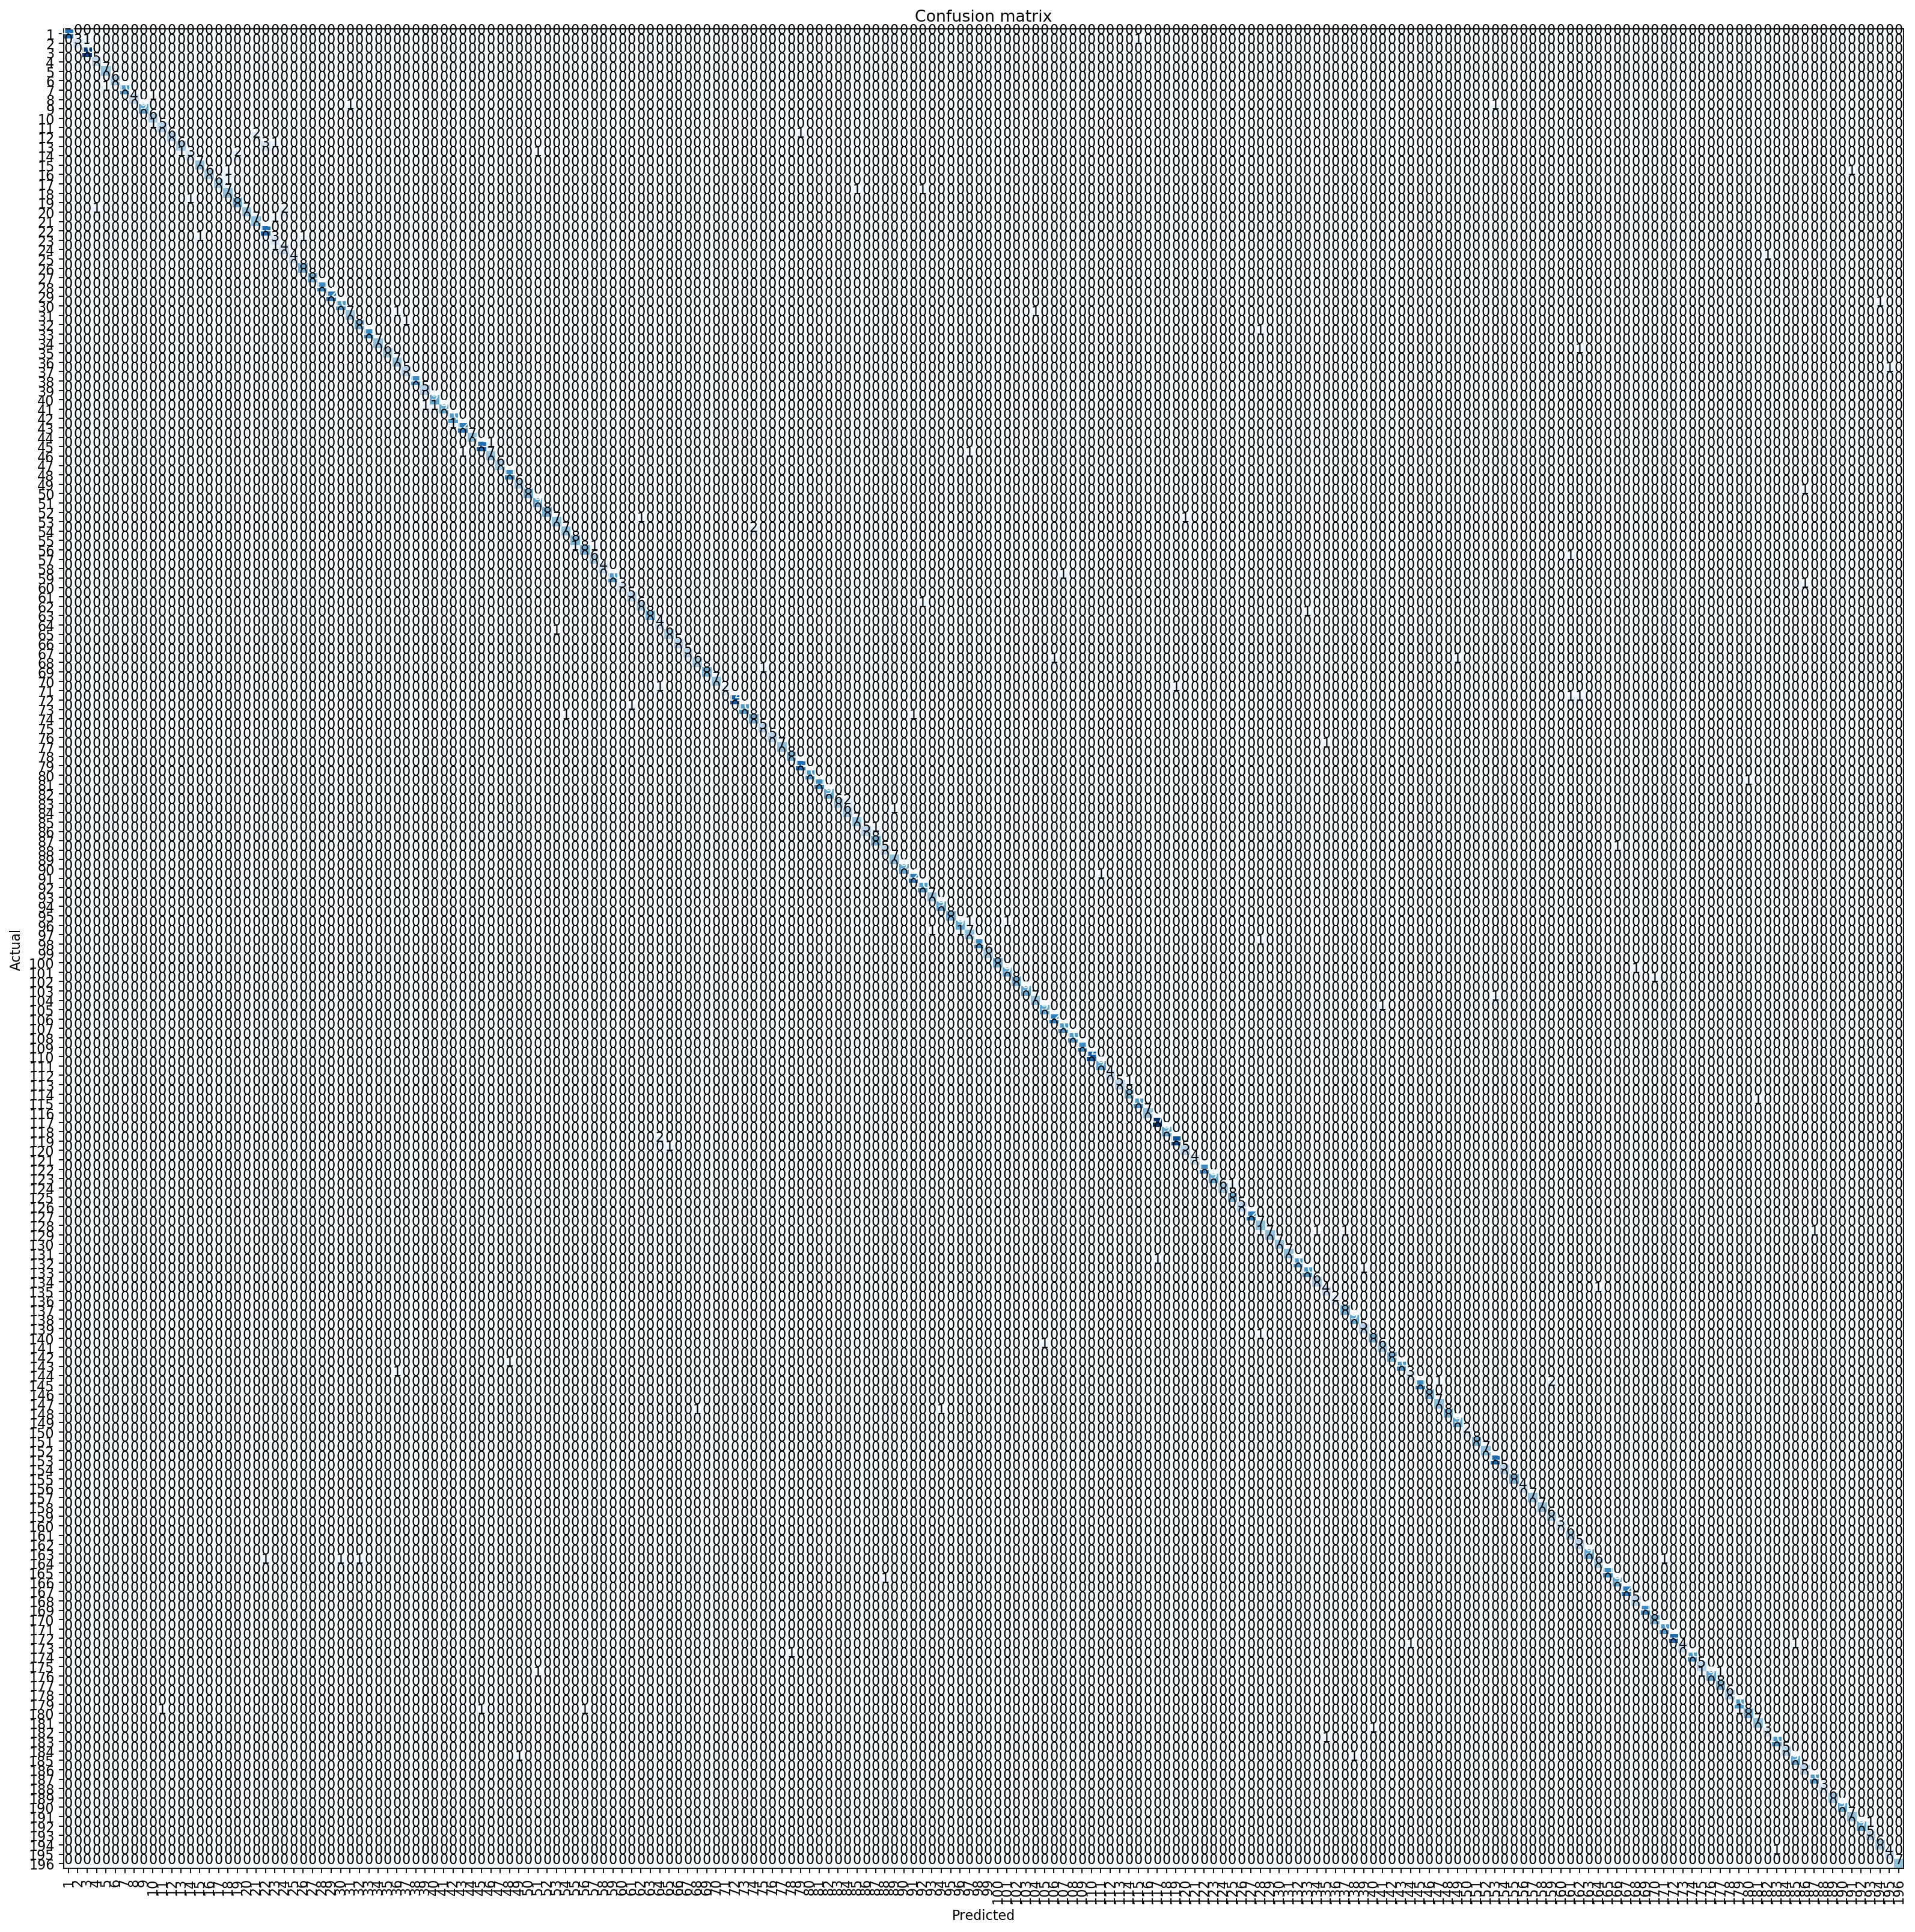

In [12]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=160)

In [13]:
interp.most_confused(min_val=1)

[(103, 104, 3),
 (12, 21, 2),
 (13, 22, 2),
 (14, 19, 2),
 (20, 24, 2),
 (30, 35, 2),
 (43, 42, 2),
 (64, 71, 2),
 (71, 64, 2),
 (145, 159, 2),
 (178, 183, 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [8]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.649584,0.369815,0.109608


In [25]:
learn.load('stage-1');

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


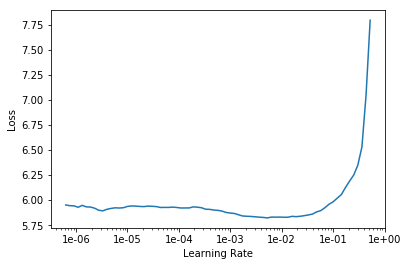

In [9]:
learn.recorder.plot()

In [17]:
doc(learn.fit_one_cycle)

In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,1.617980,1.046515,0.285627
2,1.216034,0.844251,0.232801


In [18]:
learn.save('stage-1-e10');

In [19]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,1.115378,0.843654,0.228501


In [22]:
learn.fit_one_cycle(1, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.829920,0.761107,0.205160


In [23]:
learn.save('stage-1-e12');

In [26]:
defaults.wd

0.01

In [27]:
learn.fit_one_cycle(1, max_lr=slice(2e-6,2e-4), wd=1e-4)

epoch,train_loss,valid_loss,error_rate
1,0.744252,0.731296,0.194717


In [28]:
learn.save('stage-1-e13');

In [7]:
learn.load('stage-1-e13');

In [10]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-4), wd=1e-4)

epoch,train_loss,valid_loss,error_rate
1,0.831931,0.352927,0.085995


In [11]:
learn.save('stage-1-e14-0.8599');

In [9]:
learn.load('stage-1-e14-0.8599');

In [10]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4), wd=1e-4)

epoch,train_loss,valid_loss,error_rate
1,0.790971,0.347608,0.071867
2,0.807847,0.346450,0.069410


In [11]:
learn.save('stage-1-e16-0.06941');

In [8]:
learn.load('stage-1-e16-0.06941');

In [11]:
learn.export()

In [10]:
torch.save(learn.model.state_dict(), path/'model.pth')

That's a pretty accurate model!